In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model("/content/drive/My Drive/stacked-bi-lstm.h5")
model2 = load_model("/content/drive/My Drive/stacked-bi-gru.h5")
model3 = load_model("/content/drive/My Drive/parallel-bi-lstm-bi-gru.h5")


In [ ]:
import pandas as pd
import json
import os
import random

# Load dataset from JSONL file
def load_dataset(file_path):
    dataset = []
    with open(file_path, 'r') as file:
        for line in file:
            example = json.loads(line)
            dataset.append(example)
    return dataset

# Define file paths
train_file = '/content/drive/My Drive/Hateful-memes/data/train.jsonl'
image_directory = '/content/drive/My Drive/Hateful-memes/data/'

# Load train dataset
train_dataset = load_dataset(train_file)

# Randomly choose 4000 entries
random.seed(42)  # Set seed for reproducibility
chosen_examples = random.sample(train_dataset, 4000)

# Create DataFrame
data = []
for idx, example in enumerate(chosen_examples):
    text = example['text']
    img_path = os.path.join(image_directory, example['img'])
    label = example['label']
    data.append({'id': idx, 'img_text': text, 'img_path': img_path, 'label': label})

df = pd.DataFrame(data)

# Display DataFrame
print(df.head())


   id                                           img_text  \
0   0  they arent bad if you raise them properly same...   
1   1                         the fuck did you just say?   
2   2  fresh out of fb jail and still not giving a fuck!   
3   3                  loves me some boneless jungle ham   
4   4     ilhan omar sporting her beautiful purple hijab   

                                            img_path  label  
0  /content/drive/My Drive/Hateful-memes/data/img...      0  
1  /content/drive/My Drive/Hateful-memes/data/img...      0  
2  /content/drive/My Drive/Hateful-memes/data/img...      0  
3  /content/drive/My Drive/Hateful-memes/data/img...      0  
4  /content/drive/My Drive/Hateful-memes/data/img...      0  


In [ ]:
from tensorflow.keras.models import Model

# Remove the second-to-last layer (the dropout layer)
feature_extractor_model = Model(inputs=model1.input, outputs=model1.layers[-3].output)

In [ ]:
# Assuming you have a function to preprocess the text into the required format
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z]', ' ', text)
    text = text.lower()
    return text
tokenizer = Tokenizer()

In [ ]:
def extract_features(df, feature_extractor_model, tokenizer, max_sequence_length=128):
    preprocessed_texts = [preprocess_text(text) for text in df['img_text']]
    tokenized_texts = tokenizer.texts_to_sequences(preprocessed_texts)
    padded_texts = pad_sequences(tokenized_texts, maxlen=max_sequence_length, padding='post', truncating='post')
    features = feature_extractor_model.predict(padded_texts)
    return features

In [ ]:
from tensorflow.keras.models import Model

# Remove the second-to-last layer (the dropout layer)
feature_extractor_model2 = Model(inputs=model2.input, outputs=model2.layers[-3].output)

In [ ]:
from tensorflow.keras.models import Model

# Remove the second-to-last layer (the dropout layer)
feature_extractor_model3 = Model(inputs=model3.input, outputs=model3.layers[-3].output)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)  # Change the number of labels accordingly

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_model.to(device)

checkpoint = torch.load("/content/drive/MyDrive/bert_hs.pth", map_location=device)
bert_model.load_state_dict(checkpoint)

bert_model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cpu")
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

def extract_features(text):

    tokenized_text = bert_tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True, padding='max_length')

    input_ids = torch.tensor([tokenized_text]).to(device)

    with torch.no_grad():
        bert_model.eval()
        outputs = bert_model(input_ids)
        encoder_outputs = outputs.last_hidden_state  # Accessing the last layer hidden states

    return encoder_outputs


In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame without headers
w = pd.read_csv("/content/drive/My Drive/weighted_features.csv", header=None)

# Display the DataFrame
print(w)

           0         1         2         3         4         5         6    \
0     0.068760  0.006914  0.655712 -0.018400  0.045860 -0.137267  0.428607   
1     0.332996  0.018946  0.055867 -0.042622 -0.177406  0.231200  0.136041   
2    -0.311119  0.631305 -0.007867 -0.080991 -0.144436 -0.896535  0.121868   
3    -0.004184  0.065663 -0.232954 -0.377676 -0.360994  0.707565  0.328306   
4    -0.163816  0.479926  0.062636  0.075246 -0.084321  0.177070 -0.419044   
...        ...       ...       ...       ...       ...       ...       ...   
3995  0.022336 -0.674554 -0.105085  0.997326 -0.029520 -0.114630 -0.093246   
3996 -0.251770 -0.363803  0.411863 -0.210013 -0.199557  0.087292  0.319589   
3997 -0.047597 -0.053898 -0.051306 -0.050684  0.073650  0.145640 -0.094576   
3998  0.336502  0.176163 -0.180504 -0.036967  0.254505 -0.198949  0.279880   
3999  0.207203  0.347588  0.135088  0.425267  0.250840  0.081257  0.366132   

           7         8         9    ...       790       791    

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Function to extract features from an image
def extract_featuresi(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Load image
    img_array = img_to_array(img)  # Convert image to numpy array
    img_array = preprocess_input(img_array)  # Preprocess input according to the requirements of VGG16
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    features = base_model.predict(img_array)  # Extract features using VGG16
    return features.flatten()  # Flatten the features


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Extract features for each image in img_array
features_list = []
for image_path in df['img_path'][:4000]:  # Considering 4000 entries
    features = extract_featuresi(image_path)
    features_list.append(features)

1/1 [==============================] - 0s 477ms/step


In [ ]:
print(len(features_list))
print(len(features_list[0]))

4000
25088


In [ ]:
print(features_list[1])

[ 0.       0.       0.      ...  0.      36.51307  0.     ]


In [ ]:
w.head(3)

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.068760,0.006914,0.655712,-0.018400,0.045860,-0.137267,0.428607,0.047399,0.062788,0.056465,...,0.194684,0.360684,0.045896,0.658951,0.294665,-0.493537,-0.340314,0.401199,-0.036893,0.150310
1,0.332996,0.018946,0.055867,-0.042622,-0.177406,0.231200,0.136041,-0.077666,-0.369159,-0.520990,...,-0.135568,0.239431,0.132145,-0.380651,0.699423,0.205703,-0.495900,0.618121,-0.630585,-0.040682
2,-0.311119,0.631305,-0.007867,-0.080991,-0.144436,-0.896535,0.121868,-0.198130,0.254805,0.088481,...,0.674240,0.074411,-0.215691,0.147831,0.223285,0.326422,0.423236,0.354083,-0.173611,0.175316


In [ ]:
features_df = pd.DataFrame(features_list)

ValueError: Must pass 2-d input. shape=(4000, 1, 512)

In [ ]:
print(features_list[1])

[ 0.       0.       0.      ...  0.      36.51307  0.     ]


In [ ]:
import pandas as pd

# Assuming `w` and `features_df` are your DataFrames
combined_df = pd.concat([w, features_df], axis=1)

# Display the combined DataFrame
print(combined_df)


         0         1         2         3         4         5         6      \
0     0.068760  0.006914  0.655712 -0.018400  0.045860 -0.137267  0.428607   
1     0.332996  0.018946  0.055867 -0.042622 -0.177406  0.231200  0.136041   
2    -0.311119  0.631305 -0.007867 -0.080991 -0.144436 -0.896535  0.121868   
3    -0.004184  0.065663 -0.232954 -0.377676 -0.360994  0.707565  0.328306   
4    -0.163816  0.479926  0.062636  0.075246 -0.084321  0.177070 -0.419044   
...        ...       ...       ...       ...       ...       ...       ...   
3995  0.022336 -0.674554 -0.105085  0.997326 -0.029520 -0.114630 -0.093246   
3996 -0.251770 -0.363803  0.411863 -0.210013 -0.199557  0.087292  0.319589   
3997 -0.047597 -0.053898 -0.051306 -0.050684  0.073650  0.145640 -0.094576   
3998  0.336502  0.176163 -0.180504 -0.036967  0.254505 -0.198949  0.279880   
3999  0.207203  0.347588  0.135088  0.425267  0.250840  0.081257  0.366132   

         7         8         9      ...      25078      25079  

In [ ]:
# Save the array to a CSV file
np.savetxt('combined_features.csv', combined_df, delimiter=',')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Assuming combined_df is your DataFrame with features
features = combined_df.values  # Extract features
labels = df['label'].values  # Extract labels

In [ ]:
print(features.shape)
print(features)
print(labels)

NameError: name 'features' is not defined

In [ ]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert input data to float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# Define the neural network model with dropout
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
100/100 [==============================] - 12s 93ms/step - loss: 1.6518 - accuracy: 0.5387 - val_loss: 0.6934 - val_accuracy: 0.6150
Epoch 2/10
100/100 [==============================] - 13s 131ms/step - loss: 0.9129 - accuracy: 0.5816 - val_loss: 0.6843 - val_accuracy: 0.6425
Epoch 3/10
100/100 [==============================] - 14s 138ms/step - loss: 0.7711 - accuracy: 0.6200 - val_loss: 0.6476 - val_accuracy: 0.6388
Epoch 4/10
100/100 [==============================] - 10s 103ms/step - loss: 0.6898 - accuracy: 0.6478 - val_loss: 0.6428 - val_accuracy: 0.6587
Epoch 5/10
100/100 [==============================] - 10s 102ms/step - loss: 0.6746 - accuracy: 0.6562 - val_loss: 0.6438 - val_accuracy: 0.6662
Epoch 6/10
100/100 [==============================] - 14s 142ms/step - loss: 0.6248 - accuracy: 0.6809 - val_loss: 0.6385 - val_accuracy: 0.6600
Epoch 7/10
100/100 [==============================] - 12s 124ms/step - loss: 0.5758 - accuracy: 0.7159 - val_loss: 0.6508 - val_acc

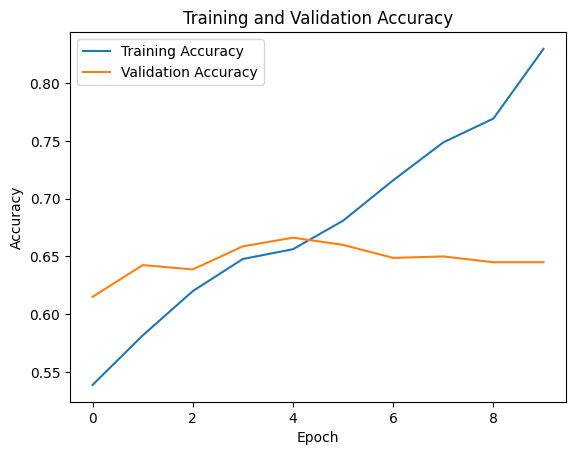

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# Save the model architecture to JSON file
model_json = model.to_json()
with open("model_nn.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to HDF5 file
model.save_weights("model_nn.h5")


AttributeError: 'CLIP' object has no attribute 'to_json'

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=bb85ef5e356d97bb1b3a6b7e1d7bab98a90ffe6f952b09b8b63c9d34d2f33c2a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer


In [ ]:
import json
from tensorflow.keras.models import model_from_json

with open("/content/drive/My Drive/model_nn.json", "r") as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

model.load_weights("/content/drive/My Drive/model_nn.h5")


In [ ]:
explainer = LimeTextExplainer(class_names=['hate'])

In [ ]:
def predict_proba(texts):
    # Use the ensemble model to get predictions

    predictions_list = []

    print(len(texts))

    tokenizer = Tokenizer()
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    for text in texts:
        tokenizer = Tokenizer()

        tokenized_text = tokenizer.texts_to_sequences([text])
        padded_text = pad_sequences(tokenized_text, maxlen=128, padding='post', truncating='post')

        features1 = feature_extractor_model.predict(padded_text)
        features2 = feature_extractor_model2.predict(padded_text)
        features3 = feature_extractor_model3.predict(padded_text)

        featuresb = extract_features(text)

        # Convert featuresb to a tuple
        featuresb = (featuresb,)

        # Concatenate the tensors along a new dimension
        concatenated_features = torch.cat(featuresb, dim=0)

        # Convert the concatenated tensor to a NumPy array
        features_array = concatenated_features.cpu().numpy()

        # Compute the mean of the feature vectors for each text
        mean_features_list = np.mean(features_array, axis=1)

        mean_features_list = np.resize(mean_features_list, (1, 800))

        weighted_features = 0.7 * mean_features_list + 0.1 * features1 + 0.1 * features2 + 0.1 * features3

        # Concatenate the reshaped weighted features with features along axis 1
        concatenated_features = np.concatenate((weighted_features, [features]), axis=1)

        # Make the prediction
        prediction = model.predict(concatenated_features)


        print(prediction[0])

        predictions_list.append(prediction[0])

    return np.array(predictions_list)


In [ ]:
# Find the row corresponding to ID 29814
row = df[df['id'] == 788]

print(row)

# Extract the text and image path
text = preprocess_text(row['img_text'].values[0])
image_path = row['img_path'].values[0]

features = extract_featuresi(image_path)

print(text)
print(image_path)
print(features.shape)

      id                                           img_text  \
788  788  tresspass on federal land and we'll stalk, hun...   

                                              img_path  label  
788  /content/drive/My Drive/Hateful-memes/data/img...      1  
1/1 [==============================] - 1s 1s/step
tresspass on federal land and we ll stalk  hunt  and kill you           unless you are mexican
/content/drive/My Drive/Hateful-memes/data/img/34618.png
(25088,)


In [ ]:
# Get the explanation
explanation = explainer.explain_instance(text, predict_proba, num_features=10, top_labels=1,num_samples=100)

100
1/1 [==============================] - 3s 3s/step


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


1/1 [==============================] - 0s 83ms/step
[0.85823256]
1/1 [==============================] - 0s 23ms/step
[0.857984]
1/1 [==============================] - 0s 24ms/step
[0.85891324]
1/1 [==============================] - 0s 24ms/step
[0.8586718]
1/1 [==============================] - 0s 28ms/step
[0.8577184]
1/1 [==============================] - 0s 24ms/step
[0.8582302]
1/1 [==============================] - 0s 32ms/step
[0.8579087]
1/1 [==============================] - 0s 30ms/step
[0.85817206]
1/1 [==============================] - 0s 34ms/step
[0.8585116]
1/1 [==============================] - 0s 25ms/step
[0.8583675]
1/1 [==============================] - 0s 24ms/step
[0.8589173]
1/1 [==============================] - 0s 26ms/step
[0.85813016]
1/1 [==============================] - 0s 25ms/step
[0.8586611]
1/1 [==============================] - 0s 23ms/step
[0.85798985]
1/1 [==============================] - 0s 23ms/step
[0.8591683]
1/1 [==============================]

In [ ]:
# Visualize the explanation
explanation.show_in_notebook(text=True)

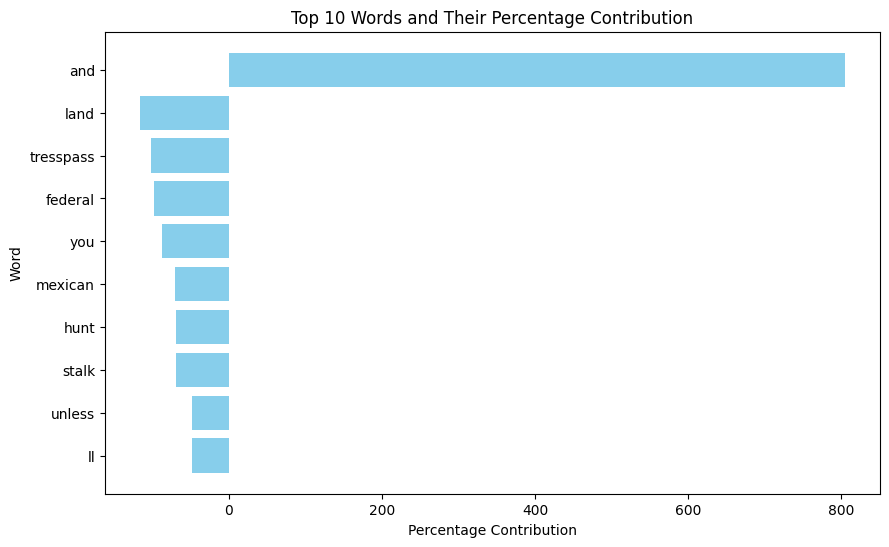

In [ ]:
import matplotlib.pyplot as plt

# Get the feature importance and words from the explanation
word_importance = explanation.as_list(label=0)  # Assuming you're interested in the first (and only) label
words = [word for word, _ in word_importance]
importance_scores = [score for _, score in word_importance]

# Normalize importance scores to get percentage contribution
total_importance = sum(importance_scores)
percentage_contributions = [(score / total_importance) * 100 for score in importance_scores]

# Plot the percentage contributions
plt.figure(figsize=(10, 6))
plt.barh(words, percentage_contributions, color='skyblue')
plt.xlabel('Percentage Contribution')
plt.ylabel('Word')
plt.title('Top 10 Words and Their Percentage Contribution')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()


In [ ]:
concatenated_features = np.concatenate((weighted_features_reshaped, [features]), axis=1)
print(concatenated_features.shape)
print(weighted_features.shape)
print(concatenated_features)

(1, 25888)
(1, 800)
[[ 0.13173237 -0.07566353  0.6732053  ...  0.          0.
  68.01813   ]]


In [ ]:
import lime
from lime import lime_image


In [ ]:
# Function to extract features from an image
def extract_load_featuresi(img_array):
    img_array = preprocess_input(img_array)  # Preprocess input according to the requirements of VGG16
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    features = base_model.predict(img_array)  # Extract features using VGG16
    return features.flatten()  # Flatten the features


In [ ]:
def predict_probai(images):
    # Use the ensemble model to get predictions

    predictions_list = []

    print(len(images))

    for image in images:

        features = extract_load_featuresi(image)

        # Concatenate the reshaped weighted features with features along axis 1
        concatenated_features = np.concatenate((weighted_features, [features]), axis=1)

        # Make the prediction
        prediction = model.predict(concatenated_features)

        print(prediction[0])

        predictions_list.append(prediction[0])

    return np.array(predictions_list)

In [ ]:
tokenizer = Tokenizer()
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_text = tokenizer.texts_to_sequences([text])
padded_text = pad_sequences(tokenized_text, maxlen=128, padding='post', truncating='post')

features1 = feature_extractor_model.predict(padded_text)
features2 = feature_extractor_model2.predict(padded_text)
features3 = feature_extractor_model3.predict(padded_text)

featuresb = extract_features(text)

# Convert featuresb to a tuple
featuresb = (featuresb,)

# Concatenate the tensors along a new dimension
concatenated_features = torch.cat(featuresb, dim=0)

# Convert the concatenated tensor to a NumPy array
features_array = concatenated_features.cpu().numpy()

# Compute the mean of the feature vectors for each text
mean_features_list = np.mean(features_array, axis=1)

mean_features_list = np.resize(mean_features_list, (1, 800))

weighted_features = 0.7 * mean_features_list + 0.1 * features1 + 0.1 * features2 + 0.1 * features3

1/1 [==============================] - 0s 71ms/step


In [ ]:
# Create a LIME image explainer
explainer = lime_image.LimeImageExplainer()

In [ ]:
image = load_img(image_path, target_size=(224, 224))  # Load image
img_array = img_to_array(image)  # Convert image to numpy array

In [ ]:
print(image)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7DD069303640>


In [ ]:
# Get the explanation
explanation = explainer.explain_instance(img_array, predict_probai, hide_color=0, num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

10
1/1 [==============================] - 0s 43ms/step
[0.85823256]
1/1 [==============================] - 0s 34ms/step
[0.28785783]
1/1 [==============================] - 0s 54ms/step
[0.34934923]
1/1 [==============================] - 0s 63ms/step
[0.48648512]
1/1 [==============================] - 0s 47ms/step
[0.28855956]
1/1 [==============================] - 0s 89ms/step
[0.48740876]
1/1 [==============================] - 0s 34ms/step
[0.2575801]
1/1 [==============================] - 0s 126ms/step
[0.33889836]
1/1 [==============================] - 0s 104ms/step
[0.5162764]
1/1 [==============================] - 0s 127ms/step
[0.62547433]
10
1/1 [==============================] - 0s 140ms/step
[0.6145734]
1/1 [==============================] - 0s 152ms/step
[0.27001315]
1/1 [==============================] - 0s 38ms/step
[0.74697113]
1/1 [==============================] - 0s 40ms/step
[0.8125113]
1/1 [==============================] - 0s 117ms/step
[0.65745777]
1/1 [============

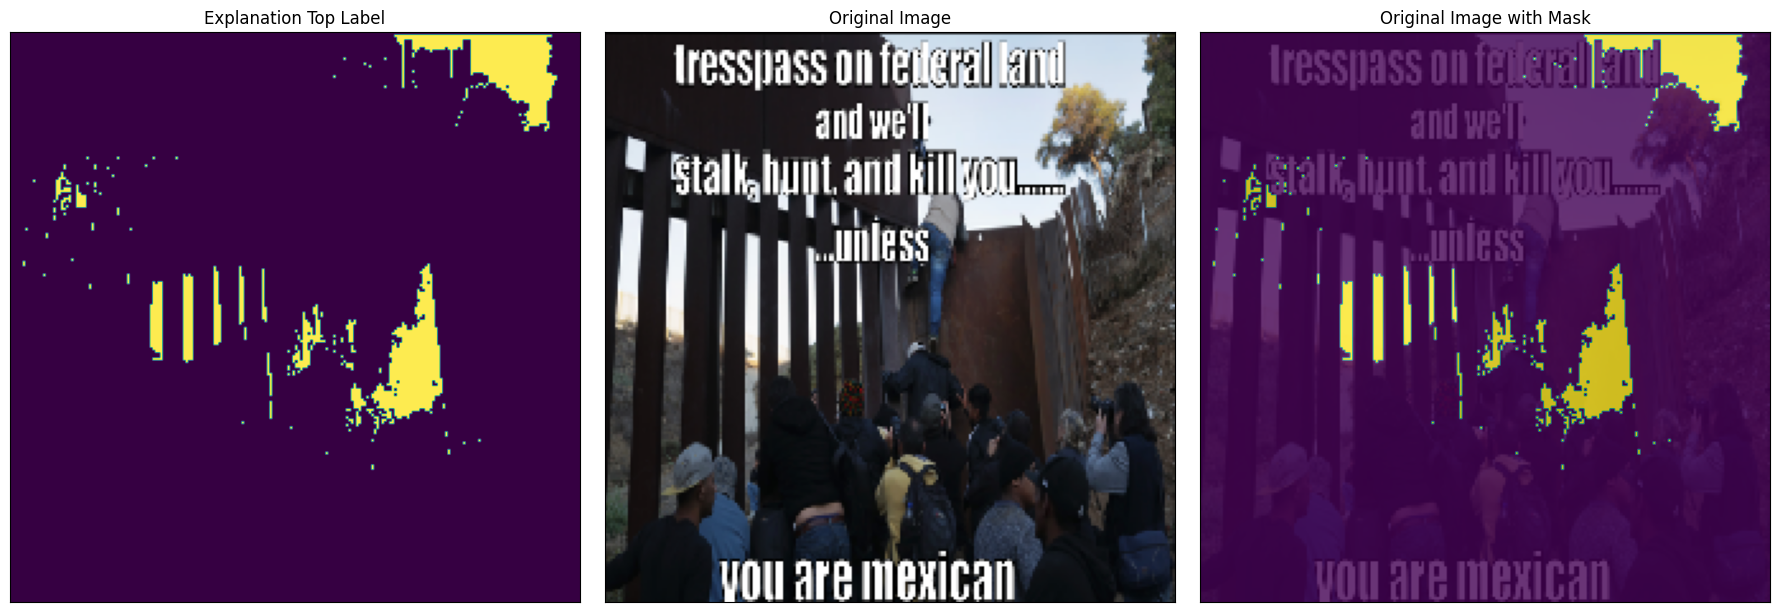

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis for subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Get image and mask for explanation top label
imagex, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# Display image and mask for explanation top label
axs[0].imshow(imagex)
axs[0].imshow(mask, alpha=0.8)
axs[0].set_title('Explanation Top Label')

# Display original image
axs[1].imshow(image)
axs[1].set_title('Original Image')

# Display original image with mask
axs[2].imshow(image)
axs[2].imshow(mask, alpha=0.8)
axs[2].set_title('Original Image with Mask')

# Hide axes ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [ ]:
pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p2tqi9fv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p2tqi9fv
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 549.7 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=bce8db78df37ff5295dbc43a6cfaec25bc5c6cd3d1015cbed4981124e6a7f5e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-e5rmti22/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import clip

# Get the list of available models
available_models = clip.available_models()

# Print the available models
print(available_models)


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [ ]:
import clip
from PIL import Image
import numpy as np

# Load the CLIP model and processor
model, preprocess = clip.load("ViT-B/32")


In [ ]:
# Function to extract features from an image
def extract_features(image_path):
    # Load image
    image = Image.open(image_path)

    # Preprocess image
    image_input = preprocess(image).unsqueeze(0)

    # Forward pass through the model
    with torch.no_grad():
        image_features = model.encode_image(image_input)

    # Convert tensor to numpy array
    image_features = image_features.cpu().numpy()

    return image_features

In [ ]:
# Extract features for each image in img_array
features_list = []
for image_path in df['img_path'][:4000]:  # Considering 4000 entries
    features = extract_features(image_path)
    features_list.append(features)

In [ ]:
print(len(features_list))
print(len(features_list[0][0]))

4000
512


In [ ]:
import pandas as pd
import numpy as np

# Reshape the arrays in features_list
reshaped_features_list = [arr.reshape(-1) for arr in features_list]

# Create a DataFrame
features_df = pd.DataFrame(reshaped_features_list)

# Check the shape
print(features_df.shape)


(4000, 512)


In [ ]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.270273,-0.029868,-0.128431,0.566323,0.283010,-0.423404,-0.030108,-0.114930,0.691817,0.101995,...,-0.204093,-0.156968,-0.501102,-0.164789,-0.389767,0.739437,-0.172282,0.452726,0.133648,-0.341942
1,0.085504,-0.277406,0.181758,0.334139,0.072009,-0.829496,-0.143900,0.633656,0.779807,0.284120,...,0.047652,-0.310867,1.263918,-0.450944,0.056577,-0.339455,-0.151970,0.201300,0.226529,-0.251272
2,-0.034533,-0.128344,0.088784,0.129072,-0.172672,-0.098207,-0.170040,0.433562,-0.224112,0.108946,...,0.155274,-0.083793,-0.036935,-0.312663,0.007059,0.404402,0.500997,0.776452,0.109735,-0.107602
3,-0.133741,0.192133,0.062278,-0.031606,0.197741,-0.465606,-0.247924,0.408179,0.617435,0.523829,...,0.046297,0.012690,0.278957,-0.241798,-0.424606,0.329259,0.130987,0.647757,-0.100042,0.028036
4,0.189942,0.007463,0.198725,0.181875,0.097050,-0.302187,0.047295,-0.243337,0.405451,-0.099333,...,-0.262157,-0.358216,0.778531,0.424586,-0.218628,0.159936,-0.070916,0.233732,-0.028552,-0.393545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.394997,-0.012073,0.080570,0.441322,-0.593966,0.063416,0.418146,0.234171,-0.252266,0.118629,...,-0.474135,0.148159,0.968503,-0.274990,-0.239338,0.052149,-0.002328,0.480705,0.109786,0.152070
3996,-0.036166,0.071982,0.143566,0.366528,0.029159,-0.525195,0.292979,-0.035654,0.300651,0.067375,...,-0.417960,-0.147650,-0.032524,0.141608,-0.092332,0.181201,-0.567081,0.183370,-0.213019,-0.486833
3997,-0.234494,0.067451,-0.561449,0.104077,0.295783,-0.161284,0.079802,0.093993,-0.196710,-0.039102,...,-0.459447,-0.007592,-0.052290,0.429941,-0.167030,-0.221438,-0.407765,0.526786,-0.104706,-0.627236
3998,0.071574,0.285286,-0.097112,0.135712,0.095681,-0.268515,0.172202,0.170537,-0.562941,-0.045243,...,0.056155,0.526726,0.669539,-0.590676,0.155384,-0.372917,-0.483796,0.168404,0.208574,-0.047468


In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame without headers
w = pd.read_csv("/content/drive/My Drive/weighted_features.csv", header=None)

# Display the DataFrame
print(w)

           0         1         2         3         4         5         6    \
0     0.068760  0.006914  0.655712 -0.018400  0.045860 -0.137267  0.428607   
1     0.332996  0.018946  0.055867 -0.042622 -0.177406  0.231200  0.136041   
2    -0.311119  0.631305 -0.007867 -0.080991 -0.144436 -0.896535  0.121868   
3    -0.004184  0.065663 -0.232954 -0.377676 -0.360994  0.707565  0.328306   
4    -0.163816  0.479926  0.062636  0.075246 -0.084321  0.177070 -0.419044   
...        ...       ...       ...       ...       ...       ...       ...   
3995  0.022336 -0.674554 -0.105085  0.997326 -0.029520 -0.114630 -0.093246   
3996 -0.251770 -0.363803  0.411863 -0.210013 -0.199557  0.087292  0.319589   
3997 -0.047597 -0.053898 -0.051306 -0.050684  0.073650  0.145640 -0.094576   
3998  0.336502  0.176163 -0.180504 -0.036967  0.254505 -0.198949  0.279880   
3999  0.207203  0.347588  0.135088  0.425267  0.250840  0.081257  0.366132   

           7         8         9    ...       790       791    

In [ ]:
w.head(3)

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.068760,0.006914,0.655712,-0.018400,0.045860,-0.137267,0.428607,0.047399,0.062788,0.056465,...,0.194684,0.360684,0.045896,0.658951,0.294665,-0.493537,-0.340314,0.401199,-0.036893,0.150310
1,0.332996,0.018946,0.055867,-0.042622,-0.177406,0.231200,0.136041,-0.077666,-0.369159,-0.520990,...,-0.135568,0.239431,0.132145,-0.380651,0.699423,0.205703,-0.495900,0.618121,-0.630585,-0.040682
2,-0.311119,0.631305,-0.007867,-0.080991,-0.144436,-0.896535,0.121868,-0.198130,0.254805,0.088481,...,0.674240,0.074411,-0.215691,0.147831,0.223285,0.326422,0.423236,0.354083,-0.173611,0.175316


In [ ]:
import pandas as pd

# Assuming `w` and `features_df` are your DataFrames
combined_df = pd.concat([w, features_df], axis=1)

# Display the combined DataFrame
print(combined_df)


           0         1         2         3         4         5         6    \
0     0.068760  0.006914  0.655712 -0.018400  0.045860 -0.137267  0.428607   
1     0.332996  0.018946  0.055867 -0.042622 -0.177406  0.231200  0.136041   
2    -0.311119  0.631305 -0.007867 -0.080991 -0.144436 -0.896535  0.121868   
3    -0.004184  0.065663 -0.232954 -0.377676 -0.360994  0.707565  0.328306   
4    -0.163816  0.479926  0.062636  0.075246 -0.084321  0.177070 -0.419044   
...        ...       ...       ...       ...       ...       ...       ...   
3995  0.022336 -0.674554 -0.105085  0.997326 -0.029520 -0.114630 -0.093246   
3996 -0.251770 -0.363803  0.411863 -0.210013 -0.199557  0.087292  0.319589   
3997 -0.047597 -0.053898 -0.051306 -0.050684  0.073650  0.145640 -0.094576   
3998  0.336502  0.176163 -0.180504 -0.036967  0.254505 -0.198949  0.279880   
3999  0.207203  0.347588  0.135088  0.425267  0.250840  0.081257  0.366132   

           7         8         9    ...       502       503    

In [ ]:
# Save the array to a CSV file
np.savetxt('clip_combined_features.csv', combined_df, delimiter=',')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Assuming combined_df is your DataFrame with features
features = combined_df.values  # Extract features
labels = df['label'].values  # Extract labels


In [ ]:
print(features.shape)
print(features)
print(labels)

(4000, 1312)
[[ 0.06875953  0.00691448  0.65571219 ...  0.45272633  0.13364837
  -0.34194195]
 [ 0.33299586  0.01894608  0.05586695 ...  0.20130043  0.22652894
  -0.25127161]
 [-0.31111869  0.63130516 -0.00786716 ...  0.77645206  0.10973541
  -0.10760155]
 ...
 [-0.04759745 -0.05389754 -0.05130582 ...  0.52678597 -0.10470563
  -0.62723571]
 [ 0.33650166  0.17616275 -0.18050385 ...  0.16840376  0.20857446
  -0.04746775]
 [ 0.20720261  0.3475877   0.1350878  ... -0.0830587  -0.42532867
  -0.1270683 ]]
[0 0 0 ... 0 1 1]


In [ ]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert input data to float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout

# Define the neural network model with dropout
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/30
100/100 [==============================] - 6s 26ms/step - loss: 0.6571 - accuracy: 0.6356 - val_loss: 0.6358 - val_accuracy: 0.6488
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.6247 - accuracy: 0.6538 - val_loss: 0.6269 - val_accuracy: 0.6687
Epoch 3/30
100/100 [==============================] - 2s 21ms/step - loss: 0.6015 - accuracy: 0.6778 - val_loss: 0.6220 - val_accuracy: 0.6650
Epoch 4/30
100/100 [==============================] - 2s 18ms/step - loss: 0.5775 - accuracy: 0.7038 - val_loss: 0.6135 - val_accuracy: 0.6687
Epoch 5/30
100/100 [==============================] - 1s 13ms/step - loss: 0.5476 - accuracy: 0.7234 - val_loss: 0.6283 - val_accuracy: 0.6625
Epoch 6/30
100/100 [==============================] - 1s 13ms/step - loss: 0.5119 - accuracy: 0.7550 - val_loss: 0.6505 - val_accuracy: 0.6700
Epoch 7/30
100/100 [==============================] - 1s 13ms/step - loss: 0.4872 - accuracy: 0.7581 - val_loss: 0.6658 - val_accuracy: 0.6687

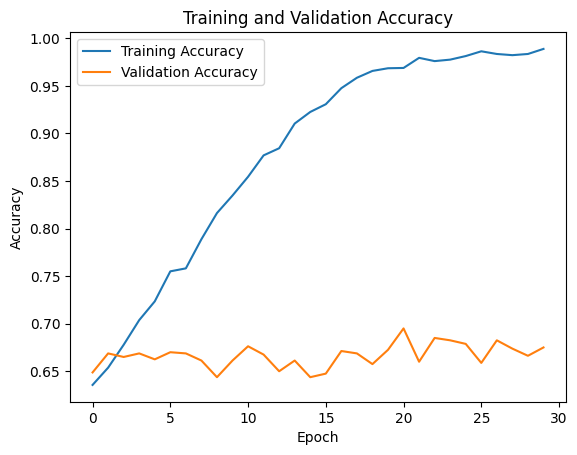

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
